## Part 3 — 3D Mesh Rendering on a Planar Target

This notebook is a **clean, reader-friendly** walkthrough of **Part 3**.

Aligned with the real project code:
- Calibration loading: `camera.py` → `load_calibration_npz`
- Tracking (2D corners): `tracker.py` → `PlanarTracker`
- Pose + rendering: `ar_render.py` → `load_mesh_trimesh`, `transform_mesh_to_plane`, `draw_mesh_wireframe`, `draw_mesh_flat`, `scale_K_to_new_size`, `make_plane_object_points`
- Parameters: `config.py` → `Part3Config`, `Part1Config`

### Goal
Track the planar target, estimate pose (`solvePnP`), then **project and render a 3D mesh** onto the video frame.

---

### Setup
Run from inside the `augmented-reality-planar/` folder so relative `data/...` paths resolve.


In [16]:
from pathlib import Path
import importlib

import cv2
import numpy as np
import matplotlib.pyplot as plt

import config as cfg_mod
from tracker import PlanarTracker
from camera import load_calibration_npz
from ar_render import (
    load_mesh_trimesh,
    make_demo_tetrahedron,
    transform_mesh_to_plane,
    draw_mesh_wireframe,
    draw_mesh_flat,
    scale_K_to_new_size,
    make_plane_object_points,
)

# If you edited config.py recently, reload so the notebook uses the latest defaults.
importlib.reload(cfg_mod)

ROOT = Path().resolve()
cfg3 = cfg_mod.Part3Config()
tracker_cfg = cfg_mod.Part1Config()

print("cfg3.model_path:", repr(cfg3.model_path))

calib = load_calibration_npz(str(ROOT / cfg3.calib_output_path))
print("calibration image_size:", calib.image_size)
print("calibration rms:", calib.rms)


cfg3.model_path: 'data/models/86jfmjiufzv2.obj'
calibration image_size: (4284, 5712)
calibration rms: 1.0413850545883179


### Step 1 — Load inputs (reference + one video frame)

We render on **one frame** first (fast + easy to debug).


(1080, 1920)

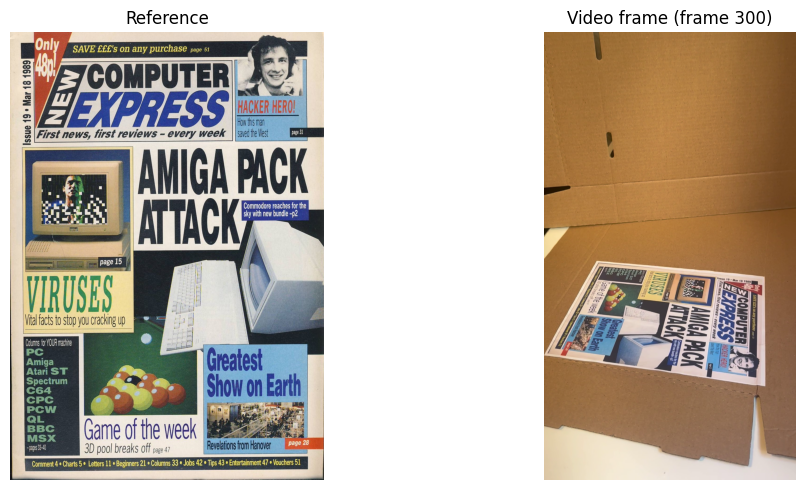

In [17]:
ref_path = ROOT / cfg3.reference_path
video_path = ROOT / cfg3.video_path

# Choose which video frame to render on
frame_idx = 300 # change this (e.g., 120, 250, ...)

ref_bgr = cv2.imread(str(ref_path))
assert ref_bgr is not None, f"Could not read reference: {ref_path}"

cap = cv2.VideoCapture(str(video_path))
assert cap.isOpened(), f"Could not open video: {video_path}"

out_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
ok, frame_bgr = cap.read()
cap.release()
assert ok and frame_bgr is not None, f"Could not read frame {frame_idx}"

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(cv2.cvtColor(ref_bgr, cv2.COLOR_BGR2RGB))
ax[0].set_title("Reference")
ax[1].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"Video frame (frame {frame_idx})")
for a in ax:
    a.axis("off")
plt.tight_layout()

(out_w, out_h)


### Step 2 — Prepare camera parameters and plane geometry

Same logic as `main.py`: scale `K` if calibration resolution differs from the video resolution, and define 4 object points on the plane (Z=0).


In [18]:
K_calib = np.asarray(calib.K, dtype=np.float64).reshape(3, 3)
dist = np.asarray(calib.dist, dtype=np.float64).reshape(-1, 1)

K = K_calib
if tuple(calib.image_size) != (out_w, out_h):
    K = scale_K_to_new_size(K_calib, tuple(calib.image_size), (out_w, out_h))
K = np.asarray(K, dtype=np.float64).reshape(3, 3)

ref_h, ref_w = ref_bgr.shape[:2]
ref_aspect = ref_h / float(ref_w)
plane_w = float(cfg3.plane_width)
plane_h = float(cfg3.plane_width) * ref_aspect
obj_plane = np.ascontiguousarray(make_plane_object_points(plane_w, plane_h), dtype=np.float64).reshape(-1, 3)

print("plane (w,h):", plane_w, plane_h)
print("K:\n", K)


plane (w,h): 1.0 1.4258333333333333
K:
 [[1.02087237e+03 0.00000000e+00 5.38220019e+02]
 [0.00000000e+00 1.36038846e+03 9.58303200e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Step 3 — Load a mesh and place it on the plane

We reuse `transform_mesh_to_plane()` so the model is scaled/positioned consistently with the real Part 3 implementation.


In [19]:
# Load mesh (from config)
# `cfg3.model_path` comes from `config.py` (Part3Config).

if not str(cfg3.model_path).strip():
    raise ValueError(
        "cfg3.model_path is empty. Restart the kernel to pick up the latest config.py, or set Part3Config.model_path."
    )

model_path = (ROOT / cfg3.model_path)

# Guard against the exact failure you saw: passing a directory to trimesh
if model_path.exists() and model_path.is_dir():
    raise ValueError(f"cfg3.model_path points to a directory, not a file: {model_path}")

if model_path.exists():
    v, f, face_colors = load_mesh_trimesh(str(model_path))
    print("loaded mesh (cfg3.model_path):", model_path)
else:
    v, f = make_demo_tetrahedron()
    face_colors = None
    print("using demo tetrahedron (model file not found):", model_path)

# Optional downsample for speed (mirrors main.py: sample faces across the mesh)
if cfg3.max_faces and int(cfg3.max_faces) > 0 and f.shape[0] > int(cfg3.max_faces):
    rng = np.random.default_rng(0)
    idx = rng.choice(f.shape[0], size=int(cfg3.max_faces), replace=False)
    f = f[idx]
    if face_colors is not None and face_colors.shape[0] >= idx.max() + 1:
        face_colors = face_colors[idx]

v_plane = transform_mesh_to_plane(
    v,
    plane_w=plane_w,
    plane_h=plane_h,
    scale_frac=cfg3.model_scale_frac,
    offset_x_frac=cfg3.model_offset_x_frac,
    offset_y_frac=cfg3.model_offset_y_frac,
    z_up=True,
    rotate_x_deg=cfg3.rotate_x_deg,
    rotate_y_deg=cfg3.rotate_y_deg,
    rotate_z_deg=cfg3.rotate_z_deg,
)

(v_plane.shape, f.shape, None if face_colors is None else face_colors.shape)


loaded mesh (cfg3.model_path): C:\Users\nirdu\Documents\ComputerVision_Course\Project_AR\augmented-reality-planar\data\models\86jfmjiufzv2.obj


((169374, 3), (65000, 3), (65000, 4))

### Step 4 — Track the plane, estimate pose, and render

We use:
- `PlanarTracker` for 2D corners
- `solvePnP` for pose
- `projectPoints` + `draw_mesh_*` for rendering


tracking dbg: {'good': 797, 'inliers': 517, 'held': 0, 'smoothed': 0}


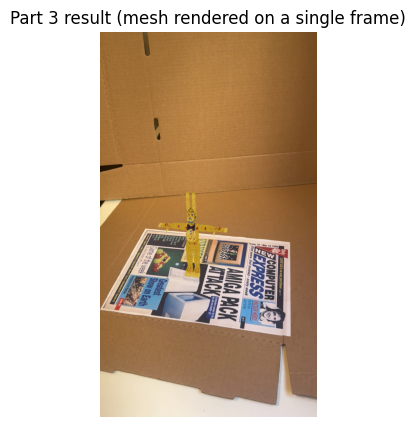

In [20]:
tracker = PlanarTracker(ref_bgr, tracker_cfg)
H, corners, dbg = tracker.track(frame_bgr)
print("tracking dbg:", dbg)

out = frame_bgr.copy()

if corners is not None:
    img_pts = np.asarray(corners, dtype=np.float64).reshape(-1, 2)
    if img_pts.shape == (4, 2) and np.isfinite(img_pts).all():
        ok_pnp = False
        try:
            if hasattr(cv2, "SOLVEPNP_IPPE"):
                try:
                    ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_IPPE))
                except cv2.error:
                    ok_pnp = False
                if not ok_pnp:
                    ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
            else:
                ok_pnp, rvec, tvec = cv2.solvePnP(obj_plane, img_pts, K, dist, flags=int(cv2.SOLVEPNP_ITERATIVE))
        except cv2.error:
            ok_pnp = False

        if ok_pnp:
            proj, _ = cv2.projectPoints(v_plane, rvec, tvec, K, dist)
            verts2d = proj.reshape(-1, 2)

            # Painter order (far -> near) like main.py
            R, _ = cv2.Rodrigues(rvec)
            cam = (R @ v_plane.T + tvec).T
            z = cam[:, 2]
            face_depth = z[f].mean(axis=1)
            order = np.argsort(face_depth)[::-1]

            if face_colors is not None:
                out = draw_mesh_flat(out, verts2d, f, face_colors, order=order)
            else:
                out = draw_mesh_wireframe(out, verts2d, f, color=(0, 255, 255), thickness=1)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("Part 3 result (mesh rendered on a single frame)")
plt.axis("off")
plt.show()
